# notebook.ipynb
This is a sample notebook and web application which shows how Amazon Bedrock can be used with Neo4j. We will explore how to leverage generative AI to build and consume a knowledge graph in Neo4j.

The dataset we're using is from the SEC's EDGAR system.  It was downloaded using [these scripts](https://github.com/neo4j-partners/neo4j-sec-edgar-form13).

The dataflow in this demo consists of two parts:
1. Ingestion - we read the EDGAR files with Bedrock, extracting entities and relationships from them.  Bedrock then generates Neo4j Cypher that is run against a Neo4j database deployed from AWS Marketplace.
2. Consumption - A user inputs natural language into a web UI.  Bedrock converts that to Neo4j Cypher which is run against the database.  This flow allows non technical users to query the database.


## Setup
This notebook runs well within SageMaker.  Open your SageMaker domain.  Clone this GitHub repo.  Then open this notebook and select the SageMaker Data Science 3.0 image.

Now, let's install Bedrock libraries. Currently they are in preview. So, you have to download them here and unzip to a folder.

In [4]:
%pip uninstall -y botocore
%pip uninstall -y boto3

Found existing installation: botocore 1.29.162
Uninstalling botocore-1.29.162:
  Successfully uninstalled botocore-1.29.162
Note: you may need to restart the kernel to use updated packages.
Found existing installation: boto3 1.26.162
Uninstalling boto3-1.26.162:
  Successfully uninstalled boto3-1.26.162
Note: you may need to restart the kernel to use updated packages.


In [5]:
!wget -O /root/bedrock-python-sdk.zip https://preview.documentation.bedrock.aws.dev/Documentation/SDK/bedrock-python-sdk.zip
!unzip /root/bedrock-python-sdk.zip -d /root/bedrock-python-sdk

--2023-08-23 19:14:07--  https://preview.documentation.bedrock.aws.dev/Documentation/SDK/bedrock-python-sdk.zip
Resolving preview.documentation.bedrock.aws.dev (preview.documentation.bedrock.aws.dev)... failed: Name or service not known.
wget: unable to resolve host address ‘preview.documentation.bedrock.aws.dev’
Archive:  /root/bedrock-python-sdk.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /root/bedrock-python-sdk.zip or
        /root/bedrock-python-sdk.zip.zip, and cannot find /root/bedrock-python-sdk.zip.ZIP, period.


Make sure the `boto` & `botocore` libs correspond to the right version of your downloaded SDK. And then execute the code below

In [6]:
%pip install /root/bedrock-python-sdk/boto3-1.26.162-py3-none-any.whl --force-reinstall
%pip install /root/bedrock-python-sdk/botocore-1.29.162-py3-none-any.whl --force-reinstall

Processing /root/bedrock-python-sdk/boto3-1.26.162-py3-none-any.whl
  Using cached botocore-1.29.165-py3-none-any.whl (11.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 1.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.7/247.7 kB 3.8 MB/s eta 0:00:0000:01
  Using cached urllib3-1.26.16-py2.py3-none-any.whl (143 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.16
    Uninstalling urllib3-1.26.16:
      Successfully uninstalled urllib3-1.26.16
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: jmespath
    Found existing installation: jmespath 0.10.0
    Uninstalling jmespath-0.10.0:
      Successfully uninstalled jmespath-0.10.0
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.2
    Uninstalling python-dateutil-2.8.2:
      Successfully uninstalled py

In [36]:
%pip install --user "langchain>=0.0.237"
%pip install --user graphdatascience
%pip install --user pydantic
%pip install --user IProgress
%pip install --user tqdm
%pip install --user gradio


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 35.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━

Now restart the kernel.  That will allow the Python evironment to import the new packages.

In [8]:
SERVICE_NAME = 'bedrock'
REGION_NAME = 'us-west-2'

In [9]:
import boto3
import json
bedrock = boto3.client(
 service_name=SERVICE_NAME,
 region_name=REGION_NAME,
 endpoint_url=f'https://{SERVICE_NAME}.{REGION_NAME}.amazonaws.com'
)

## Prompt Definition
In the upcoming sections, we will extract knowledge adhering to the following schema. This is a very Simplified schema to extract only the information we are interested in. Normally, you will have Domain Experts who come up with an ideal Schema. Neo4j being a schema-flexible database, the schema can be modified later to accomodate new data



Schema:
````
(:Manager{name:string})-[:OWNS{reportCalendarOrQuarter:string,value:number,sshPrnamt:number,sshPrnamtType:string,investmentDiscretion:string,votingSole:number,votingShared:number,votingNone:number}]->(:Company{nameOfIssuer:string,cusip:string})
(:Manager{name:string})-[:HAS_ADDRESS]->(Address{street1:string,street2:string,city:string,stateOrCountry:string,zipCode:string})

````






To achieve our Extraction goal as per the schema, I am going to chain a series of prompts, each focused on only one task - to extract a specific entity. By this way, you can go for more granular extraction. The prompts I used here can be improved and in production scenario, you should consider running QA on the prompt pipelines to ensure that the extracted information is correct. Also, you should consider a landing and serving zones and ensure only curated data lands the serving zone.

Let's go in this order to gather the data in accordance to out data model:
1. Extract Manager Information
2. Extract Filing Information

## Data Preparation and Helper functions
Our input source is a `txt` file served from a URL. So, lets write some code to extract and convert the txt to json.

In [10]:
import json
inp_text = ''
with open('./data/raw_2023-05-15_archives_edgar_data_1027451_0000919574-23-003245.txt') as f:
    inp_text = f.read()

Now, let's write some helper functions to call Bedrock's Titan model

In [11]:
import traceback
def call_language_model(prompt_data):
    try:
        body = json.dumps({"prompt": f"Human: {prompt_data} \n Assistant:",
                           "temperature":0,
                           "top_k":1, "top_p":0.88,
                           "anthropic_version":"bedrock-2023-05-31",
                           "max_tokens_to_sample": 2048
                          })
        modelId = 'anthropic.claude-v2' # change this to use a different version from the model provider
        accept = 'application/json'
        contentType = 'application/json'

        response = bedrock.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
        response_body = json.loads(response.get('body').read())

        return response_body.get('completion')
    except Exception as e:
        traceback.format_exc()
        print(e)

Now, lets define the prompts to enable our extraction process

In [12]:
import json
import re

def extract_json_from_string(input_string):
    pattern = r'\{.*?\}|\[.*?\]'
    match = re.search(pattern, input_string.replace('\n', ' ').replace('```', ''))
    if match:
        return json.loads(match.group())

The first part of the Input text contains Manager information and the latter is filing info. 
Lets break them up to avoid LLM token limitations 

In [13]:
parts = inp_text.split('</edgarSubmission>') #splits the text into manager details and filing details
manager_info = parts[0]
filing_info = parts[1]

Sometimes `filing_info` can be larger text beyond the limits of LLM input length. So, lets split that up to chunks

In [14]:
import numpy as np
import re
def split_filing_info(s):
    pattern = '(</(\w+:)?infoTable>)'
    splitter = re.findall(pattern, s)[0][0]
    _parts = s.split(splitter)
    if len(_parts) > 15:
        chunks_of_list = np.array_split(_parts, len(_parts)/15) # max 15 filings per part
        chunks_of_str = map(lambda x: splitter.join(x), chunks_of_list)
        return list(chunks_of_str)
    else:
        return [s]

filing_info_chunks = split_filing_info(filing_info)
len(filing_info_chunks)

2

## Extract Manager info

In [15]:
mgr_info_tpl="""From the text below, extract the following as json. Do not miss any of these information.
* The tags mentioned below may or may not namespaced. So extract accordingly. Eg: <ns1:tag> is equal to <tag>
* "name" - The name from the <name> tag under <filingManager> tag
* "street1" - The manager's street1 address from the <com:street1> tag under <address> tag
* "street2" - The manager's street2 address from the <com:street2> tag under <address> tag
* "city" - The manager's city address from the <com:city> tag under <address> tag
* "stateOrCountry" - The manager's stateOrCountry address from the <com:stateOrCountry> tag under <address> tag
* "zipCode" - The manager's zipCode from the <com:zipCode> tag under <address> tag
* "reportCalendarOrQuarter" - The reportCalendarOrQuarter from the <reportCalendarOrQuarter> tag under <address> tag
* Just return me the JSON enclosed by 3 backticks. No other text in the response

Text:
$ctext
"""

In [16]:
from string import Template
import json
prompt = Template(mgr_info_tpl).substitute(ctext=manager_info)
manager_info = json.loads(call_language_model(prompt).split('```')[1].strip('json'))
manager_info

{'name': 'TIGER MANAGEMENT L.L.C.',
 'street1': '101 PARK AVENUE',
 'street2': None,
 'city': 'NEW YORK',
 'stateOrCountry': 'NY',
 'zipCode': '10178',
 'reportCalendarOrQuarter': '03-31-2023'}

## Extract Filing Information

In [17]:
filing_info_tpl = """From the text below, extract the following as a list of json enclosed by 3 back ticks. You will find many filing information under the <infoTable> tag. Extract all of them.
* "nameOfIssuer" - The name from the <nameOfIssuer> tag under <infoTable> tag
* "cusip" - The cusip from the <cusip> tag under <infoTable> tag
* "value" - The value from the <value> tag under <infoTable> tag
* "sshPrnamt" - The sshPrnamt from the <sshPrnamt> tag under <infoTable> tag
* "sshPrnamtType" - The sshPrnamtType from the <sshPrnamtType> tag under <infoTable> tag
* "investmentDiscretion" - The investmentDiscretion from the <investmentDiscretion> tag under <infoTable> tag
* "votingSole" - The votingSole from the <votingSole> tag under <infoTable> tag
* "votingShared" - The votingShared from the <votingShared> tag under <infoTable> tag
* "votingNone" - The votingNone from the <votingNone> tag under <infoTable> tag

Text:
$ctext
"""

In [18]:
filings = []
for chunk in filing_info_chunks:
    prompt = Template(filing_info_tpl).substitute(ctext=chunk)
    response = json.loads(call_language_model(prompt).split('```')[1].strip('json'))
    filings = filings + response

len(filings)

33

## Data Ingestion Cypher Generation

The entities and relationships we got from the LLM have to be transformed to Cypher so we can write them into Neo4j.

In [26]:
import re

def get_cypher_compliant_var(_id):
    s = re.sub(r'[\W_]', '', _id).lower() #avoid numbers appearing as firstchar; replace spaces
    return s[:20] #restrict variable size

def generate_cypher(manager, filings):
    cyphers = []
    create_manager = f'MERGE (mgr:Manager{{name: "{manager["name"]}"}})'
    cyphers.append(create_manager)
    
    addr_id = get_cypher_compliant_var(manager["name"])
    create_address = f'''MERGE (addr:Address{{id: "{addr_id}"}})
    ON CREATE SET addr.street1 = "{manager["street1"]}",
    addr.street2 = "{manager["street2"]}",
    addr.city = "{manager["city"]}",
    addr.stateOrCountry = "{manager["stateOrCountry"]}",
    addr.zipCode = "{manager["zipCode"]}"
    '''
    cyphers.append(create_address)
    
    relate_mgr_addr = f'''MATCH (mgr:Manager{{name: "{manager["name"]}"}})
      MATCH (addr:Address{{id: "{addr_id}"}})
      MERGE (mgr)-[:HAS_ADDRESS]->(addr)'''
    cyphers.append(relate_mgr_addr)
    
    for f in filings:
        create_company = f'''MERGE (co:Company{{cusip: "{f['cusip']}"}}) 
        ON CREATE SET co.nameOfIssuer = "{f["nameOfIssuer"]}"'''
        cyphers.append(create_company)
        
        on_create_set = f"""o.reportCalendarOrQuarter = "{manager['reportCalendarOrQuarter']}",
               o.value = {float(f.get('value', 0))},
               o.sshPrnamt = {float(f.get('sshPrnamt', 0))},
               o.sshPrnamtType = "{f.get('sshPrnamtType', '')}",
               o.investmentDiscretion = "{f.get('investmentDiscretion', '')}",
               o.votingSole = {int(f.get('votingSole', '0'))},
               o.votingShared = {int(f.get('votingShared', '0'))},
               o.votingNone = {int(f.get('votingNone', '0'))}"""
        on_merge_set = f"""o.value = o.value + {float(f.get('value', 0))},
               o.sshPrnamt = o.sshPrnamt + {float(f.get('sshPrnamt', 0))},
               o.votingSole = o.votingSole + {int(f.get('votingSole', '0'))},
               o.votingShared = o.votingShared + {int(f.get('votingShared', '0'))},
               o.votingNone = o.votingNone + {int(f.get('votingNone', '0'))}"""
        relate_mgr_co = f'''MATCH (mgr:Manager{{name: "{manager["name"]}"}})
          MATCH (co:Company{{cusip: "{f['cusip']}"}})
          MERGE (mgr)-[o:OWNS]->(co)
          ON CREATE SET {on_create_set}
          ON MATCH SET {on_merge_set}
          '''
        cyphers.append(relate_mgr_co)
        
    return cyphers
         

In [27]:
ingestion_cypher = generate_cypher(manager_info, filings)
len(ingestion_cypher)

69

## Data Ingestion
You will need a Neo4j instance.  You can deploy that on AWS Marketplace [here](https://aws.amazon.com/marketplace/pp/prodview-akmzjikgawgn4).  Be sure to deploy a single node and select GDS.  We're going to need the GDS libraries available.

With that complete, you'll need to install the Neo4j library and set up your database connection.

In [28]:
from graphdatascience import GraphDataScience

# username is neo4j by default
username = 'neo4j'

# You will need to change these variables
connectionUrl = 'neo4j://ben-genai-nlb-666285e1a164bc96.elb.us-east-1.amazonaws.com:7687'
password = 'foobar123'

In [29]:
gds = GraphDataScience(
    connectionUrl,
    auth=(username, password),
    )

gds.set_database("neo4j")

Before loading the data, create constraints as below

In [30]:
gds.run_cypher('CREATE CONSTRAINT unique_manager IF NOT EXISTS FOR (n:Manager) REQUIRE (n.name) IS UNIQUE')
gds.run_cypher('CREATE CONSTRAINT unique_address_id IF NOT EXISTS FOR (n:Address) REQUIRE (n.id) IS UNIQUE')
gds.run_cypher('CREATE CONSTRAINT unique_company_id IF NOT EXISTS FOR (n:Company) REQUIRE (n.cusip) IS UNIQUE')

""


In [31]:
%%time
from tqdm import tqdm
for e in tqdm(ingestion_cypher):
    gds.run_cypher(e)

100%|██████████| 69/69 [00:15<00:00,  4.50it/s]

CPU times: user 319 ms, sys: 35.5 ms, total: 355 ms
Wall time: 15.3 s


Your ingested data from the above commands might look like this:
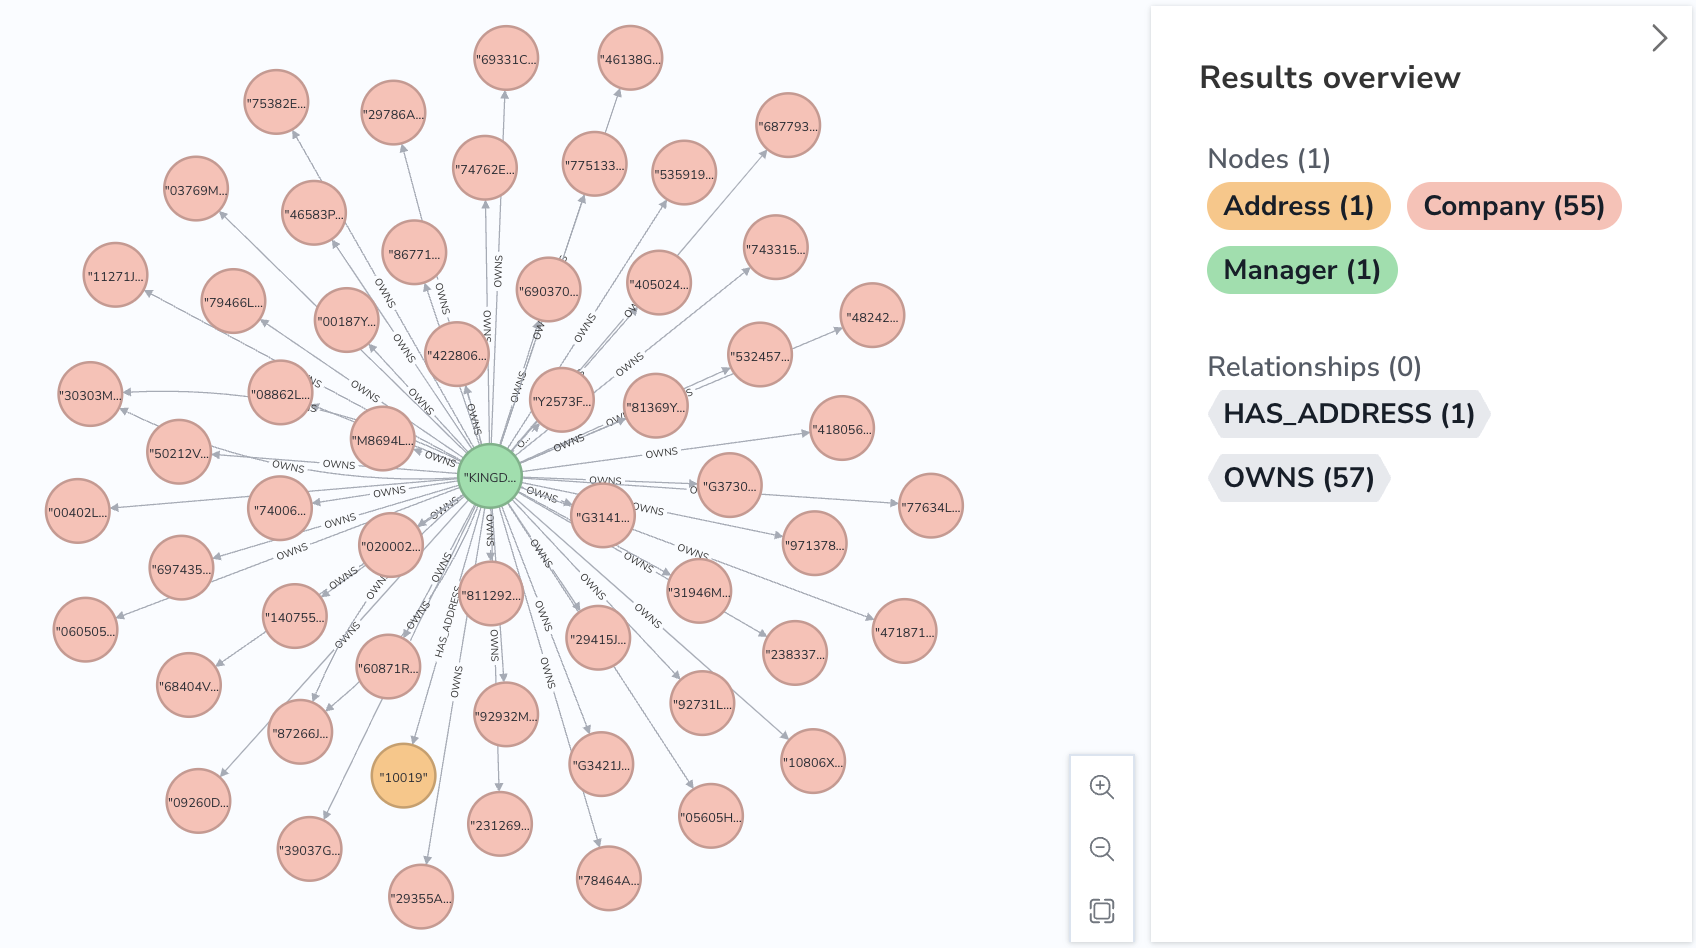

Lets feed the pipeline of EDGAR files, feed to the LLM and ingest to Neo4j

In [32]:
import glob
from string import Template
import json
from pathlib import Path
from tqdm import tqdm

def run_pipeline(start=0, count=1):
    txt_files = glob.glob("data/*.txt")[start:count]
    print(f"Running pipeline for {len(txt_files)} files")
    failed_files = process_pipeline(txt_files)
    print(failed_files)
    return failed_files

def process_pipeline(files):
    failed_files = []
    i = 0
    for f in files:
        i += 1
        try:
            with open(f, 'r', encoding='utf-8', errors='ignore') as file:
                print(f"  {f}: Reading File No. ({i})")
                data = file.read().rstrip()
                text = data
                print(f"    {f}: Extracting Entities & Relationships")
                manager, filings = run_extraction(f, text)
                print(f"    {f}: Generating Cypher")
                cyphers = generate_cypher(manager, filings)
                print(f"    {f}: Ingesting Data")
                for e in tqdm(cyphers, desc="Ingesting Data"):
                    gds.run_cypher(e)
                print(f"    {f}: Processing DONE")
        except Exception as e:
            print(f"    {f}: Processing Failed with exception {e}")
            failed_files.append(f)
    return failed_files

import numpy as np
def split_filing_info(s):
    pattern = '(</(\w+:)?infoTable>)'
    splitter = re.findall(pattern, s)[0][0]
    _parts = s.split(splitter)
    if len(_parts) > 15:
        chunks_of_list = np.array_split(_parts, len(_parts)/15) # max 15 filings per part
        chunks_of_str = map(lambda x: splitter.join(x), chunks_of_list)
        return list(chunks_of_str)
    else:
        return [s]
        
from timeit import default_timer as timer
def run_extraction(f, text):
    start = timer()
    
    parts = text.split('</edgarSubmission>') #splits the text into manager details and filing details
    manager_info = parts[0]
    filing_info = parts[1]
    
    prompt = Template(mgr_info_tpl).substitute(ctext=manager_info)
    manager = json.loads(call_language_model(prompt).split('```')[1].strip('json'))
    
    filing_info_chunks = split_filing_info(filing_info)
    filings = []
    for chunk in filing_info_chunks:
        prompt = Template(filing_info_tpl).substitute(ctext=chunk)
        response = json.loads(call_language_model(prompt).split('```')[1].strip('json'))
        filings = filings + response 
    print(f"    {f}: Total Filings: {len(filings)}")
    end = timer()
    elapsed = (end-start)
    print(f"    {f}: Entity Extraction took {elapsed}secs")
    return (manager, filings)

In [33]:
%%time
failed_files = run_pipeline(0, 5) # runs ingestion pipeline for files from index 0 to 5

Running pipeline for 5 files
  data/raw_2023-05-15_archives_edgar_data_1009258_0000950159-23-000173.txt: Reading File No. (1)
    data/raw_2023-05-15_archives_edgar_data_1009258_0000950159-23-000173.txt: Extracting Entities & Relationships
    data/raw_2023-05-15_archives_edgar_data_1009258_0000950159-23-000173.txt: Total Filings: 106
    data/raw_2023-05-15_archives_edgar_data_1009258_0000950159-23-000173.txt: Entity Extraction took 268.00801268871874secs
    data/raw_2023-05-15_archives_edgar_data_1009258_0000950159-23-000173.txt: Generating Cypher
    data/raw_2023-05-15_archives_edgar_data_1009258_0000950159-23-000173.txt: Ingesting Data


Ingesting Data: 100%|██████████| 215/215 [00:44<00:00,  4.86it/s]


    data/raw_2023-05-15_archives_edgar_data_1009258_0000950159-23-000173.txt: Processing DONE
  data/raw_2023-05-15_archives_edgar_data_11544_0000899140-23-000649.txt: Reading File No. (2)
    data/raw_2023-05-15_archives_edgar_data_11544_0000899140-23-000649.txt: Extracting Entities & Relationships
    data/raw_2023-05-15_archives_edgar_data_11544_0000899140-23-000649.txt: Total Filings: 236
    data/raw_2023-05-15_archives_edgar_data_11544_0000899140-23-000649.txt: Entity Extraction took 591.2355557689443secs
    data/raw_2023-05-15_archives_edgar_data_11544_0000899140-23-000649.txt: Generating Cypher
    data/raw_2023-05-15_archives_edgar_data_11544_0000899140-23-000649.txt: Ingesting Data


Ingesting Data:   0%|          | 0/475 [00:00<?, ?it/s]Failed to read from defunct connection ResolvedIPv4Address(('44.214.9.104', 7687)) (ResolvedIPv4Address(('44.214.9.104', 7687)))
Unable to retrieve routing information
Unable to connect to the Neo4j DBMS. Trying again...
Ingesting Data: 100%|██████████| 475/475 [01:39<00:00,  4.75it/s]


    data/raw_2023-05-15_archives_edgar_data_11544_0000899140-23-000649.txt: Processing DONE
  data/raw_2023-05-15_archives_edgar_data_1006378_0001006378-23-000007.txt: Reading File No. (3)
    data/raw_2023-05-15_archives_edgar_data_1006378_0001006378-23-000007.txt: Extracting Entities & Relationships
    data/raw_2023-05-15_archives_edgar_data_1006378_0001006378-23-000007.txt: Total Filings: 710
    data/raw_2023-05-15_archives_edgar_data_1006378_0001006378-23-000007.txt: Entity Extraction took 1805.033942649141secs
    data/raw_2023-05-15_archives_edgar_data_1006378_0001006378-23-000007.txt: Generating Cypher
    data/raw_2023-05-15_archives_edgar_data_1006378_0001006378-23-000007.txt: Ingesting Data


Ingesting Data:   0%|          | 0/1423 [00:00<?, ?it/s]Failed to read from defunct connection ResolvedIPv4Address(('44.214.9.104', 7687)) (ResolvedIPv4Address(('44.214.9.104', 7687)))
Unable to retrieve routing information
Unable to connect to the Neo4j DBMS. Trying again...
Ingesting Data: 100%|██████████| 1423/1423 [04:52<00:00,  4.86it/s]


    data/raw_2023-05-15_archives_edgar_data_1006378_0001006378-23-000007.txt: Processing DONE
  data/raw_2023-05-15_archives_edgar_data_1009232_0001009232-23-000007.txt: Reading File No. (4)
    data/raw_2023-05-15_archives_edgar_data_1009232_0001009232-23-000007.txt: Extracting Entities & Relationships
    data/raw_2023-05-15_archives_edgar_data_1009232_0001009232-23-000007.txt: Total Filings: 225
    data/raw_2023-05-15_archives_edgar_data_1009232_0001009232-23-000007.txt: Entity Extraction took 545.2657541036606secs
    data/raw_2023-05-15_archives_edgar_data_1009232_0001009232-23-000007.txt: Generating Cypher
    data/raw_2023-05-15_archives_edgar_data_1009232_0001009232-23-000007.txt: Ingesting Data


Ingesting Data:   0%|          | 0/453 [00:00<?, ?it/s]Failed to read from defunct connection ResolvedIPv4Address(('44.214.9.104', 7687)) (ResolvedIPv4Address(('44.214.9.104', 7687)))
Unable to retrieve routing information
Unable to connect to the Neo4j DBMS. Trying again...
Ingesting Data: 100%|██████████| 453/453 [01:31<00:00,  4.93it/s]


    data/raw_2023-05-15_archives_edgar_data_1009232_0001009232-23-000007.txt: Processing DONE
  data/raw_2023-05-15_archives_edgar_data_1027451_0000919574-23-003245.txt: Reading File No. (5)
    data/raw_2023-05-15_archives_edgar_data_1027451_0000919574-23-003245.txt: Extracting Entities & Relationships
    data/raw_2023-05-15_archives_edgar_data_1027451_0000919574-23-003245.txt: Total Filings: 33
    data/raw_2023-05-15_archives_edgar_data_1027451_0000919574-23-003245.txt: Entity Extraction took 75.22649114532396secs
    data/raw_2023-05-15_archives_edgar_data_1027451_0000919574-23-003245.txt: Generating Cypher
    data/raw_2023-05-15_archives_edgar_data_1027451_0000919574-23-003245.txt: Ingesting Data


Ingesting Data: 100%|██████████| 69/69 [00:13<00:00,  5.02it/s]

    data/raw_2023-05-15_archives_edgar_data_1027451_0000919574-23-003245.txt: Processing DONE
[]
CPU times: user 12.1 s, sys: 886 ms, total: 13 s
Wall time: 1h 3min 47s


In [34]:
with open('./failed_files.json', 'w') as f:
    f.write(json.dumps(failed_files))

## Cypher Generation for Consumption

### Generate Cypher
Both Bedrock and Neo4j support LangChain.  We will be using LangChain to quickly convert English to Cypher and then executes it on Neo4j.  This is augmented using generative AI before sending the response to the user.  This makes graph consumption easier for non-cypher experts.

The diagram below shows how Neo4j and Vertex AI will interact using LangChain.

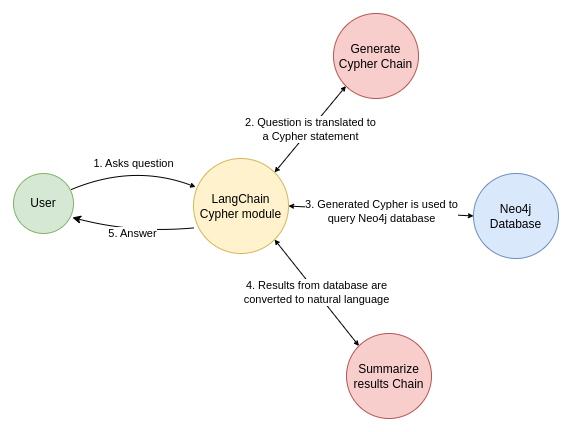

First we have to create Neo4jGraph and Bedrock Connection objects.

In [175]:
from langchain.chains import GraphCypherQAChain
from langchain.graphs import Neo4jGraph
from langchain.llms.bedrock import Bedrock
from langchain.prompts.prompt import PromptTemplate

CYPHER_GENERATION_TEMPLATE = """Human: You are an expert Neo4j Cypher translator who understands the question in english and convert to Cypher strictly based on the Neo4j Schema provided and following the instructions below:
1. Generate Cypher query compatible ONLY for Neo4j Version 5
2. Do not use EXISTS, SIZE keywords in the cypher. Use alias when using the WITH keyword
3. Use only Nodes and relationships mentioned in the schema
4. Always enclose the Cypher output inside 3 backticks
5. Always do a case-insensitive and fuzzy search for any properties related search. Eg: to search for a Company name use `toLower(c.name) contains 'neo4j'`
6. Always use aliases to refer the node in the query
7. Cypher is NOT SQL. So, do not mix and match the syntaxes
Strictly use this Schema for CYpher generation:
{schema}
Human: {question}
Assistant:
"""
CYPHER_GENERATION_PROMPT = PromptTemplate(
    input_variables=["schema", "question"], template=CYPHER_GENERATION_TEMPLATE
)

graph = Neo4jGraph(
    url=connectionUrl, 
    username='neo4j', 
    password=password
)
bedrock_llm = Bedrock(
                model_id="anthropic.claude-v2",
                client=bedrock,
                model_kwargs = {
                    "temperature":0,
                    "top_k":1, "top_p":0.1,
                    "anthropic_version":"bedrock-2023-05-31",
                    "max_tokens_to_sample": 2048
                }
            )
chain = GraphCypherQAChain.from_llm(
            bedrock_llm, graph=graph, verbose=True,
            cypher_prompt=CYPHER_GENERATION_PROMPT,
    return_direct=True
)
def summarise_results(result_json):
    summary_prompt_tpl = f"""Human: 
    Fact: {json.dumps(r['result'])}

    * Summarise the above fact as if you are answering this question "{r['query']}"
    * When the fact is not empty, assume the question is valid and the answer is true
    * Do not return helpful or extra text or apologies
    * Just return summary to the user. DO NOT start with Here is a summary
    * List the results in rich text format if there are more than one results
    Assistant:
    """
    return bedrock_llm(summary_prompt_tpl)

In [176]:
r = chain("""Which managers own Amazon?""")
summarise_results(r)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (m:Manager)-[:OWNS]->(c:Company) 
WHERE toLower(c.nameOfIssuer) CONTAINS 'amazon'
RETURN m.name AS manager


> Finished chain.


' - TIGER MANAGEMENT L.L.C.\n- MORGENS WATERFALL VINTIADIS & CO INC\n- BROOKFIELD CORP /ON/  \n- ARBOR CAPITAL MANAGEMENT INC /ADV/'

In [177]:
r = chain("""If a Manager own Amazon, do they also own Meta?""")
summarise_results(r)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (m:Manager)-[:OWNS]->(c1:Company) 
WHERE toLower(c1.nameOfIssuer) CONTAINS 'amazon'
WITH m, c1
MATCH (m)-[:OWNS]->(c2:Company)
WHERE toLower(c2.nameOfIssuer) CONTAINS 'meta'
RETURN m, c1, c2


> Finished chain.


' * MORGENS WATERFALL VINTIADIS & CO INC owns Amazon and Meta\n* BROOKFIELD CORP /ON/ owns Amazon and Meta\n* ARBOR CAPITAL MANAGEMENT INC /ADV owns Amazon but not Meta'

## Chatbot
Now we are going to use Gradio to deploy a chat interface that will have our chain behind it.

When we run the code below, a Gradio application will be deployed and can be accessed at a local URL. We also get a public URL that can be shared for 3 days.

In [38]:
import gradio as gr
import typing_extensions
from langchain.memory import ConversationBufferMemory

memory = ConversationBufferMemory(memory_key = "chat_history", return_messages = True)
llm = VertexAI(model_name='code-bison',
            max_output_tokens=2048,
            temperature=0,
            top_p=0.95,
            top_k=0.40)
agent_chain = chain

def chat_response(input_text,history):
    try:
        return agent_chain.run(input_text)
    except:
        return "I'm sorry, there was an error retrieving the information you requested."

interface = gr.ChatInterface(fn = chat_response,
                             title = "Investment Chatbot",
                             description = "powered by Neo4j",
                             theme = "soft",
                             chatbot = gr.Chatbot(height=500),
                             undo_btn = None,
                             clear_btn = "\U0001F5D1 Clear chat",
                             examples = ["Who are Tesla's top investors in last 3 months?",
                                         "What are the top 10 investments for Blackrock?",
                                         "Which manager owns FAANG stocks?",
                                         "What are other top investments for fund managers investing in Exxon?",
                                         "What are Vanguard's top investments by value for 2023?",
                                         "Who are the common investors between Tesla and Microsoft?"])

interface.launch(share=True)

ImportError: cannot import name 'deprecated' from 'typing_extensions' (/opt/conda/lib/python3.10/site-packages/typing_extensions.py)